# Stone's Data Science Test

## Dev: Mateus Broilo
mateus.brilo90@gmail.com

* Objectives: Load Datasets and perform 

 # Summary

* Initials
    * Loading Libraries and Packages
    * Configurations
    * Global Variables
* Function's Definition
    * Class of Preprocess Funtions
* Loading data
* Data Preprocessing
    * Date Resources: day_of_week,  day_name, day_of_month, pure_time, day_of_month_RANGE
    * Transactions Resources: same_day_count,  same_day_valor_count, rank_same_day, diff_time
* Selecting Possible Useful Resources
* Saving preprocessed dataset  


# Initials
* Loading Libraries and Packages
* Configuration
* Global Variables

## Loading Libraries and Packages 

In [2]:
# general
import warnings
import time
import gc

#data
import pandas as pd
import numpy as np
from datetime import (datetime, date)

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
import joblib

In [3]:
ls -l ../raw_data/

total 1736
-rw-rw-r-- 1 broilo broilo 885777 mai 20 13:57 20220520_rawdata_original.xlsx
-rw-rw-r-- 1 broilo broilo 885777 mai 20 13:57 Missão_Stone_-_Dados_de_trx.xlsx


## Configurations

In [4]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 
    'axes.titlesize': 24, 'xtick.labelsize': 14, 'ytick.labelsize': 12}

sns.set(rc=rc)
sns.set_palette("tab10")
sns.set_style("darkgrid")#sns.set_style("whitegrid")

## Global Variables

In [5]:
PATH_RAWDATA = "../raw_data/"
DATA = "20220520_rawdata_original.xlsx"
DATE = time.strftime("%Y%m%d")
#MODEL = "20220522_set1_poc_XGBClassifier.sav"
MODEL = "20220522_set1_mvp_XGBClassifier.sav"

# Function's Definition

## Class of Preprocess Funtions

In [6]:
class preprocessToolKit:
    
    def dropDuplicates(dataset):
        dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True).copy()    
        return dataset
    
    def checkTypo(dataset):
        dataset['Data'] = dataset.Dia.astype(str) + ' ' + dataset.Hora.astype(str)
        uniqueDataLen = []
        for i in range(len(dataset.Data)):
            uniqueDataLen.append(len(dataset.Data[i]))
        uniqueDataLen = list(set(uniqueDataLen))
        idx = []
        for i in range(len(dataset.Data)):
            if len(dataset.Data[i]) > 19 or len(dataset.Data[i]) < 19:
                idx.append(dataset[dataset.Data == dataset.Data[i]].index.values[0])
            else:
                None
        dataset.drop(index=idx, axis=0, inplace=True)
        return dataset
    
    def dataTimeConverter(dataset, col1, col2):
        
        # day_of_week
        dataset['day_of_week'] = list(pd.to_datetime(dataset[col1], format='%Y-%m-%d').dt.dayofweek)
        dataset['day_name'] = list(pd.to_datetime(dataset[col1], format='%Y-%m-%d').dt.day_name())#.dayofweek)

        # day_of_month
        dataset[[col1+'_Ano', col1+'_Mês', col1+'_Dia']] = dataset[col1].astype(str).str.split("-", expand=True)
        dataset.rename(columns={col1+'_Dia':'day_of_month'}, inplace=True)
        dataset['day_of_month'] = dataset['day_of_month'].astype(int)

        # pure_time
        dataset[[col2+'_HH', col2+'_MIN', col2+'_SEC']] = dataset[col2].astype(str).str.split(":", expand=True)
        dataset['pure_time'] = dataset[col2+'_HH'].astype(int) + (dataset[col2+'_MIN'].astype(int) / 60) + (dataset[col2+'_SEC'].astype(float) / 3600)

        del dataset[col1+'_Ano'], dataset[col1+'_Mês'], dataset[col2+'_HH'], dataset[col2+'_MIN'], dataset[col2+'_SEC']
        
        conditions = [
            (dataset.day_of_month <= 5),
            ((dataset.day_of_month > 5) & (dataset.day_of_month <= 10)),
            ((dataset.day_of_month > 10) & (dataset.day_of_month <= 15)),
            ((dataset.day_of_month > 15) & (dataset.day_of_month <= 20)),
            ((dataset.day_of_month > 20) & (dataset.day_of_month <= 25)),
            (dataset.day_of_month > 25),
        ]

        choices = ['1-5', '6-10', '11-15', '16-20', '21-25', '>25']

        dataset['day_of_month_RANGE'] = np.select(conditions, choices, default='Tie')
        return dataset
    
    def recorrenciaTransacaoDiaria(dataset, col1, col2):
        dataset_sameDay = dataset[['Cartão','Dia']].value_counts().to_frame().reset_index()
        dataset_sameDay.rename(columns={0:'same_day_count'}, inplace=True)
        return dataset_sameDay
    
    def recorrenciaTransacaoDiariaValor(dataset, col1, col2, col3):
        dataset_sameDayValor = dataset[['Cartão','Dia','Valor']].value_counts().to_frame().reset_index()
        dataset_sameDayValor.rename(columns={0:'same_day_valor_count'}, inplace=True)
        return dataset_sameDayValor
        
    def merges(dataset, col1, col2, col3):
        dataset_sameDay = preprocessToolKit.recorrenciaTransacaoDiaria(dataset, col1, col2)
        dataset_sameDayValor = preprocessToolKit.recorrenciaTransacaoDiariaValor(dataset, col1, col2, col3)
        dataseta = dataset.merge(
            dataset_sameDay[[col1, col2, 'same_day_count']], 
            how='left', 
            left_on = [col1, col2], 
            right_on = [col1, col2]
        )
        dataset = dataseta.merge(
            dataset_sameDayValor[[col1, col2, col3, 'same_day_valor_count']], 
            how='left', 
            left_on = [col1, col2, col3], 
            right_on = [col1, col2, col3]
        )
        dataset = dataset.sort_values(by=['Cartão','Dia','Hora']).reset_index(drop=True).copy()
        return dataset
    
    def rankTransacao(dataset):
        dataset['rank_same_day'] = dataset.groupby(by=['Cartão','Dia'])['pure_time'].rank(method='first')
        return dataset
    
    def diffTime(dataset):
        diff_time = []
        for i in range(len(dataset)):
            if dataset.rank_same_day[i] == 1:
                diff_time.append(0)
            else:
                diff_time.append(dataset.pure_time[i] - dataset.pure_time[i-1])
        dataset['diff_time'] = diff_time
        return dataset

# Loading Datasets

In [7]:
df = pd.read_excel(PATH_RAWDATA + DATA, sheet_name='Aba 2')
print(df.shape)
df

(11820, 5)


,Dia,Hora,Valor,Cartão,CBK
0,2015-06-01,00:02:25,112.00,541555******5965,NaN
1,2015-06-01,00:30:45,112.00,406669******7350,NaN
2,2015-06-01,00:43:20,18.34,541187******4535,NaN
3,2015-06-01,00:46:46,55.00,554927******5629,NaN
4,2015-06-01,00:47:50,50.00,498407******2077,NaN
...,...,...,...,...,...
11815,2015-06-29,23:33:15,161.00,406669******8294,NaN
11816,2015-06-29,23:38:18,103.50,490172******5444,NaN
11817,2015-06-29,23:40:11,60.89,498407******2600,NaN
11818,2015-06-29,23:49:48,46.00,467149******3146,NaN


# Data Preprocessing
* Drop Duplicates
* Check for typos
* Feature Engineering
    * Date Resources: day_of_week,  day_name, day_of_month, pure_time, day_of_month_RANGE
    * Transactions Resources: same_day_count,  same_day_valor_count, rank_same_day, diff_time


In [8]:
df_prep = df.copy()

## Drop Duplicates

In [9]:
#df_prep = preprocessToolKit.dropDuplicates(df_prep)
#df_prep

## Check for typos

In [10]:
df_prep = preprocessToolKit.checkTypo(df_prep)
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data
0,2015-06-01,00:02:25,112.00,541555******5965,NaN,2015-06-01 00:02:25
1,2015-06-01,00:30:45,112.00,406669******7350,NaN,2015-06-01 00:30:45
2,2015-06-01,00:43:20,18.34,541187******4535,NaN,2015-06-01 00:43:20
3,2015-06-01,00:46:46,55.00,554927******5629,NaN,2015-06-01 00:46:46
4,2015-06-01,00:47:50,50.00,498407******2077,NaN,2015-06-01 00:47:50
...,...,...,...,...,...,...
11815,2015-06-29,23:33:15,161.00,406669******8294,NaN,2015-06-29 23:33:15
11816,2015-06-29,23:38:18,103.50,490172******5444,NaN,2015-06-29 23:38:18
11817,2015-06-29,23:40:11,60.89,498407******2600,NaN,2015-06-29 23:40:11
11818,2015-06-29,23:49:48,46.00,467149******3146,NaN,2015-06-29 23:49:48


## Feature Engineering

### Date Resources: day_of_week,  day_name, day_of_month, pure_time, day_of_month_RANGE

In [11]:
df_prep = preprocessToolKit.dataTimeConverter(df_prep, 'Dia', 'Hora')
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data,day_of_week,day_name,day_of_month,pure_time,day_of_month_RANGE
0,2015-06-01,00:02:25,112.00,541555******5965,NaN,2015-06-01 00:02:25,0,Monday,1,0.040278,1-5
1,2015-06-01,00:30:45,112.00,406669******7350,NaN,2015-06-01 00:30:45,0,Monday,1,0.512500,1-5
2,2015-06-01,00:43:20,18.34,541187******4535,NaN,2015-06-01 00:43:20,0,Monday,1,0.722222,1-5
3,2015-06-01,00:46:46,55.00,554927******5629,NaN,2015-06-01 00:46:46,0,Monday,1,0.779444,1-5
4,2015-06-01,00:47:50,50.00,498407******2077,NaN,2015-06-01 00:47:50,0,Monday,1,0.797222,1-5
...,...,...,...,...,...,...,...,...,...,...,...
11815,2015-06-29,23:33:15,161.00,406669******8294,NaN,2015-06-29 23:33:15,0,Monday,29,23.554167,>25
11816,2015-06-29,23:38:18,103.50,490172******5444,NaN,2015-06-29 23:38:18,0,Monday,29,23.638333,>25
11817,2015-06-29,23:40:11,60.89,498407******2600,NaN,2015-06-29 23:40:11,0,Monday,29,23.669722,>25
11818,2015-06-29,23:49:48,46.00,467149******3146,NaN,2015-06-29 23:49:48,0,Monday,29,23.830000,>25


### Transactions Resources: same_day_count,  same_day_valor_count, rank_same_day, diff_time

In [12]:
df_prep = preprocessToolKit.merges(df_prep, 'Cartão','Dia','Valor')
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data,day_of_week,day_name,day_of_month,pure_time,day_of_month_RANGE,same_day_count,same_day_valor_count
0,2015-06-03,18:44:24,170.00,400217******0059,NaN,2015-06-03 18:44:24,2,Wednesday,3,18.740000,1-5,1,1
1,2015-06-02,22:01:56,111.65,400217******3671,NaN,2015-06-02 22:01:56,1,Tuesday,2,22.032222,1-5,1,1
2,2015-06-16,18:18:16,78.15,400217******3689,NaN,2015-06-16 18:18:16,1,Tuesday,16,18.304444,16-20,1,1
3,2015-06-15,17:17:06,110.00,400217******3922,NaN,2015-06-15 17:17:06,0,Monday,15,17.285000,11-15,1,1
4,2015-06-11,15:26:25,40.00,400217******4160,NaN,2015-06-11 15:26:25,3,Thursday,11,15.440278,11-15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2015-06-18,08:53:32,132.00,554932******9338,NaN,2015-06-18 08:53:32,3,Thursday,18,8.892222,16-20,1,1
11816,2015-06-24,22:34:23,345.00,554932******9338,NaN,2015-06-24 22:34:23,2,Wednesday,24,22.573056,21-25,1,1
11817,2015-06-19,18:36:39,100.80,558285******0863,NaN,2015-06-19 18:36:39,4,Friday,19,18.610833,16-20,1,1
11818,2015-06-05,13:34:55,70.00,558285******1792,NaN,2015-06-05 13:34:55,4,Friday,5,13.581944,1-5,1,1


In [13]:
df_prep = preprocessToolKit.rankTransacao(df_prep)
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data,day_of_week,day_name,day_of_month,pure_time,day_of_month_RANGE,same_day_count,same_day_valor_count,rank_same_day
0,2015-06-03,18:44:24,170.00,400217******0059,NaN,2015-06-03 18:44:24,2,Wednesday,3,18.740000,1-5,1,1,1.0
1,2015-06-02,22:01:56,111.65,400217******3671,NaN,2015-06-02 22:01:56,1,Tuesday,2,22.032222,1-5,1,1,1.0
2,2015-06-16,18:18:16,78.15,400217******3689,NaN,2015-06-16 18:18:16,1,Tuesday,16,18.304444,16-20,1,1,1.0
3,2015-06-15,17:17:06,110.00,400217******3922,NaN,2015-06-15 17:17:06,0,Monday,15,17.285000,11-15,1,1,1.0
4,2015-06-11,15:26:25,40.00,400217******4160,NaN,2015-06-11 15:26:25,3,Thursday,11,15.440278,11-15,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2015-06-18,08:53:32,132.00,554932******9338,NaN,2015-06-18 08:53:32,3,Thursday,18,8.892222,16-20,1,1,1.0
11816,2015-06-24,22:34:23,345.00,554932******9338,NaN,2015-06-24 22:34:23,2,Wednesday,24,22.573056,21-25,1,1,1.0
11817,2015-06-19,18:36:39,100.80,558285******0863,NaN,2015-06-19 18:36:39,4,Friday,19,18.610833,16-20,1,1,1.0
11818,2015-06-05,13:34:55,70.00,558285******1792,NaN,2015-06-05 13:34:55,4,Friday,5,13.581944,1-5,1,1,1.0


In [14]:
df_prep = preprocessToolKit.diffTime(df_prep)
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data,day_of_week,day_name,day_of_month,pure_time,day_of_month_RANGE,same_day_count,same_day_valor_count,rank_same_day,diff_time
0,2015-06-03,18:44:24,170.00,400217******0059,NaN,2015-06-03 18:44:24,2,Wednesday,3,18.740000,1-5,1,1,1.0,0.0
1,2015-06-02,22:01:56,111.65,400217******3671,NaN,2015-06-02 22:01:56,1,Tuesday,2,22.032222,1-5,1,1,1.0,0.0
2,2015-06-16,18:18:16,78.15,400217******3689,NaN,2015-06-16 18:18:16,1,Tuesday,16,18.304444,16-20,1,1,1.0,0.0
3,2015-06-15,17:17:06,110.00,400217******3922,NaN,2015-06-15 17:17:06,0,Monday,15,17.285000,11-15,1,1,1.0,0.0
4,2015-06-11,15:26:25,40.00,400217******4160,NaN,2015-06-11 15:26:25,3,Thursday,11,15.440278,11-15,1,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2015-06-18,08:53:32,132.00,554932******9338,NaN,2015-06-18 08:53:32,3,Thursday,18,8.892222,16-20,1,1,1.0,0.0
11816,2015-06-24,22:34:23,345.00,554932******9338,NaN,2015-06-24 22:34:23,2,Wednesday,24,22.573056,21-25,1,1,1.0,0.0
11817,2015-06-19,18:36:39,100.80,558285******0863,NaN,2015-06-19 18:36:39,4,Friday,19,18.610833,16-20,1,1,1.0,0.0
11818,2015-06-05,13:34:55,70.00,558285******1792,NaN,2015-06-05 13:34:55,4,Friday,5,13.581944,1-5,1,1,1.0,0.0


## Encoding

In [15]:
df_prep = pd.get_dummies(df_prep, columns=['day_name', 'day_of_month_RANGE'])
df_prep

,Dia,Hora,Valor,Cartão,CBK,Data,day_of_week,day_of_month,pure_time,same_day_count,...,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_of_month_RANGE_1-5,day_of_month_RANGE_11-15,day_of_month_RANGE_16-20,day_of_month_RANGE_21-25,day_of_month_RANGE_6-10,day_of_month_RANGE_>25
0,2015-06-03,18:44:24,170.00,400217******0059,NaN,2015-06-03 18:44:24,2,3,18.740000,1,...,0,0,0,1,1,0,0,0,0,0
1,2015-06-02,22:01:56,111.65,400217******3671,NaN,2015-06-02 22:01:56,1,2,22.032222,1,...,0,0,1,0,1,0,0,0,0,0
2,2015-06-16,18:18:16,78.15,400217******3689,NaN,2015-06-16 18:18:16,1,16,18.304444,1,...,0,0,1,0,0,0,1,0,0,0
3,2015-06-15,17:17:06,110.00,400217******3922,NaN,2015-06-15 17:17:06,0,15,17.285000,1,...,0,0,0,0,0,1,0,0,0,0
4,2015-06-11,15:26:25,40.00,400217******4160,NaN,2015-06-11 15:26:25,3,11,15.440278,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,2015-06-18,08:53:32,132.00,554932******9338,NaN,2015-06-18 08:53:32,3,18,8.892222,1,...,0,1,0,0,0,0,1,0,0,0
11816,2015-06-24,22:34:23,345.00,554932******9338,NaN,2015-06-24 22:34:23,2,24,22.573056,1,...,0,0,0,1,0,0,0,1,0,0
11817,2015-06-19,18:36:39,100.80,558285******0863,NaN,2015-06-19 18:36:39,4,19,18.610833,1,...,0,0,0,0,0,0,1,0,0,0
11818,2015-06-05,13:34:55,70.00,558285******1792,NaN,2015-06-05 13:34:55,4,5,13.581944,1,...,0,0,0,0,1,0,0,0,0,0


# Selecting Possible Useful Resources

In [16]:
list(df_prep)

['Dia',
 'Hora',
 'Valor',
 'Cartão',
 'CBK',
 'Data',
 'day_of_week',
 'day_of_month',
 'pure_time',
 'same_day_count',
 'same_day_valor_count',
 'rank_same_day',
 'diff_time',
 'day_name_Friday',
 'day_name_Monday',
 'day_name_Saturday',
 'day_name_Sunday',
 'day_name_Thursday',
 'day_name_Tuesday',
 'day_name_Wednesday',
 'day_of_month_RANGE_1-5',
 'day_of_month_RANGE_11-15',
 'day_of_month_RANGE_16-20',
 'day_of_month_RANGE_21-25',
 'day_of_month_RANGE_6-10',
 'day_of_month_RANGE_>25']

In [17]:
selected = [
    #'Dia',
    #'Hora',
    'Valor',
    'Cartão', #-> index!
    #'CBK', #-> TARGET!
    'Data',
    #'day_of_week',
    #'day_name',
    #'day_of_month',
    'pure_time',
    #'day_of_month_RANGE',
    'same_day_count',
    'same_day_valor_count',
    'rank_same_day',
    'diff_time',
    'day_name_Friday',
    'day_name_Monday',
    'day_name_Saturday',
    'day_name_Sunday',
    'day_name_Thursday',
    'day_name_Tuesday',
    'day_name_Wednesday',
    'day_of_month_RANGE_1-5',
    'day_of_month_RANGE_11-15',
    'day_of_month_RANGE_16-20',
    'day_of_month_RANGE_21-25',
    'day_of_month_RANGE_6-10',
    'day_of_month_RANGE_>25',
    #'CBK_Não',
    #'CBK_Sim' #-> TARGET!
]

In [18]:
df_prep[selected]

,Valor,Cartão,Data,pure_time,same_day_count,same_day_valor_count,rank_same_day,diff_time,day_name_Friday,day_name_Monday,...,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_of_month_RANGE_1-5,day_of_month_RANGE_11-15,day_of_month_RANGE_16-20,day_of_month_RANGE_21-25,day_of_month_RANGE_6-10,day_of_month_RANGE_>25
0,170.00,400217******0059,2015-06-03 18:44:24,18.740000,1,1,1.0,0.0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,111.65,400217******3671,2015-06-02 22:01:56,22.032222,1,1,1.0,0.0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,78.15,400217******3689,2015-06-16 18:18:16,18.304444,1,1,1.0,0.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,110.00,400217******3922,2015-06-15 17:17:06,17.285000,1,1,1.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,40.00,400217******4160,2015-06-11 15:26:25,15.440278,1,1,1.0,0.0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11815,132.00,554932******9338,2015-06-18 08:53:32,8.892222,1,1,1.0,0.0,0,0,...,0,1,0,0,0,0,1,0,0,0
11816,345.00,554932******9338,2015-06-24 22:34:23,22.573056,1,1,1.0,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
11817,100.80,558285******0863,2015-06-19 18:36:39,18.610833,1,1,1.0,0.0,1,0,...,0,0,0,0,0,0,1,0,0,0
11818,70.00,558285******1792,2015-06-05 13:34:55,13.581944,1,1,1.0,0.0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
df_prep.set_index(['Cartão', 'Data'],inplace=True)
df_prep

Dia      Hora   Valor  CBK  \
Cartão           Data                                                    
400217******0059 2015-06-03 18:44:24 2015-06-03  18:44:24  170.00  NaN   
400217******3671 2015-06-02 22:01:56 2015-06-02  22:01:56  111.65  NaN   
400217******3689 2015-06-16 18:18:16 2015-06-16  18:18:16   78.15  NaN   
400217******3922 2015-06-15 17:17:06 2015-06-15  17:17:06  110.00  NaN   
400217******4160 2015-06-11 15:26:25 2015-06-11  15:26:25   40.00  NaN   
...                                         ...       ...     ...  ...   
554932******9338 2015-06-18 08:53:32 2015-06-18  08:53:32  132.00  NaN   
                 2015-06-24 22:34:23 2015-06-24  22:34:23  345.00  NaN   
558285******0863 2015-06-19 18:36:39 2015-06-19  18:36:39  100.80  NaN   
558285******1792 2015-06-05 13:34:55 2015-06-05  13:34:55   70.00  NaN   
558285******9240 2015-06-29 13:05:45 2015-06-29  13:05:45  132.00  NaN   

                                      day_of_week  day_of_month  pure_time  \
Cartão           Data                                                        
400217******0059 2015-06-03 18:44:24            2             3  18.740000   
400217******3671 2015-06-02 22:01:56            1             2  22.032222   
400217******3689 2015-06-16 18:18:16            1            16  18.304444   
400217******3922 2015-06-15 17:17:06            0            15  17.285000   
400217******4160 2015-06-11 15:26:25            3            11  15.440278   
...                                           ...           ...        ...   
554932******9338 2015-06-18 08:53:32            3            18   8.892222   
                 2015-06-24 22:34:23            2            24  22.573056   
558285******0863 2015-06-19 18:36:39            4            19  18.610833   
558285******1792 2015-06-05 13:34:55            4             5  13.581944   
558285******9240 2015-06-29 13:05:45            0            29  13.095833   

                                      same_day_count  same_day_valor_count  \
Cartão           Data                                                        
400217******0059 2015-06-03 18:44:24               1                     1   
400217******3671 2015-06-02 22:01:56               1                     1   
400217******3689 2015-06-16 18:18:16               1                     1   
400217******3922 2015-06-15 17:17:06               1                     1   
400217******4160 2015-06-11 15:26:25               1                     1   
...                                              ...                   ...   
554932******9338 2015-06-18 08:53:32               1                     1   
                 2015-06-24 22:34:23               1                     1   
558285******0863 2015-06-19 18:36:39               1                     1   
558285******1792 2015-06-05 13:34:55               1                     1   
558285******9240 2015-06-29 13:05:45               1                     1   

                                      rank_same_day  ...  day_name_Sunday  \
Cartão           Data                                ...                    
400217******0059 2015-06-03 18:44:24            1.0  ...                0   
400217******3671 2015-06-02 22:01:56            1.0  ...                0   
400217******3689 2015-06-16 18:18:16            1.0  ...                0   
400217******3922 2015-06-15 17:17:06            1.0  ...                0   
400217******4160 2015-06-11 15:26:25            1.0  ...                0   
...                                             ...  ...              ...   
554932******9338 2015-06-18 08:53:32            1.0  ...                0   
                 2015-06-24 22:34:23            1.0  ...                0   
558285******0863 2015-06-19 18:36:39            1.0  ...                0   
558285******1792 2015-06-05 13:34:55            1.0  ...                0   
558285******9240 2015-06-29 13:05:45            1.0  ...                0   

                                      day_name_Th

# Loading Model
* Feature Set 1
* Load XGBoost Classifier Default
* Predicted Results

## Feature Set 1

In [20]:
features_set1 = [
    'Valor',
    'pure_time',
    'same_day_count',
    'same_day_valor_count',
    'rank_same_day',
    'diff_time',
    'day_name_Friday',
    'day_name_Monday',
    'day_name_Saturday',
    'day_name_Sunday',
    'day_name_Thursday',
    'day_name_Tuesday',
    'day_name_Wednesday',
    'day_of_month_RANGE_1-5',
    'day_of_month_RANGE_11-15',
    'day_of_month_RANGE_16-20',
    'day_of_month_RANGE_21-25',
    'day_of_month_RANGE_6-10',
    'day_of_month_RANGE_>25'
]

In [21]:
df = df_prep[features_set1].copy()
print(df.shape)
df.head()

(11820, 19)


,,Valor,pure_time,same_day_count,same_day_valor_count,rank_same_day,diff_time,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday,day_of_month_RANGE_1-5,day_of_month_RANGE_11-15,day_of_month_RANGE_16-20,day_of_month_RANGE_21-25,day_of_month_RANGE_6-10,day_of_month_RANGE_>25
Cartão,Data,,,,,,,,,,,,,,,,,,,
400217******0059,2015-06-03 18:44:24,170.00,18.740000,1,1,1.0,0.0,0,0,0,0,0,0,1,1,0,0,0,0,0
400217******3671,2015-06-02 22:01:56,111.65,22.032222,1,1,1.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0
400217******3689,2015-06-16 18:18:16,78.15,18.304444,1,1,1.0,0.0,0,0,0,0,0,1,0,0,0,1,0,0,0
400217******3922,2015-06-15 17:17:06,110.00,17.285000,1,1,1.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0,0
400217******4160,2015-06-11 15:26:25,40.00,15.440278,1,1,1.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,0


## Load XGBoost Classifier Default

In [22]:
model = joblib.load(MODEL)
y_hat = model.predict(df)
y_hat_proba = model.predict_proba(df)

[20:13:59] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[20:13:59] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[20:13:59] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details a

In [23]:
y_hat

array([False, False, False, ..., False, False, False])

In [24]:
y_hat_proba

array([[9.9239147e-01, 7.6085189e-03],
       [9.9910378e-01, 8.9621794e-04],
       [9.9080741e-01, 9.1925692e-03],
       ...,
       [9.7556919e-01, 2.4430804e-02],
       [9.9922800e-01, 7.7197381e-04],
       [9.9941981e-01, 5.8017106e-04]], dtype=float32)

## Predicted Results

In [25]:
df_pred = df.copy()
df_pred['y_hat'] = y_hat
df_pred

Valor  pure_time  same_day_count  \
Cartão           Data                                                     
400217******0059 2015-06-03 18:44:24  170.00  18.740000               1   
400217******3671 2015-06-02 22:01:56  111.65  22.032222               1   
400217******3689 2015-06-16 18:18:16   78.15  18.304444               1   
400217******3922 2015-06-15 17:17:06  110.00  17.285000               1   
400217******4160 2015-06-11 15:26:25   40.00  15.440278               1   
...                                      ...        ...             ...   
554932******9338 2015-06-18 08:53:32  132.00   8.892222               1   
                 2015-06-24 22:34:23  345.00  22.573056               1   
558285******0863 2015-06-19 18:36:39  100.80  18.610833               1   
558285******1792 2015-06-05 13:34:55   70.00  13.581944               1   
558285******9240 2015-06-29 13:05:45  132.00  13.095833               1   

                                      same_day_valor_count  rank_same_day  \
Cartão           Data                                                       
400217******0059 2015-06-03 18:44:24                     1            1.0   
400217******3671 2015-06-02 22:01:56                     1            1.0   
400217******3689 2015-06-16 18:18:16                     1            1.0   
400217******3922 2015-06-15 17:17:06                     1            1.0   
400217******4160 2015-06-11 15:26:25                     1            1.0   
...                                                    ...            ...   
554932******9338 2015-06-18 08:53:32                     1            1.0   
                 2015-06-24 22:34:23                     1            1.0   
558285******0863 2015-06-19 18:36:39                     1            1.0   
558285******1792 2015-06-05 13:34:55                     1            1.0   
558285******9240 2015-06-29 13:05:45                     1            1.0   

                                      diff_time  day_name_Friday  \
Cartão           Data                                              
400217******0059 2015-06-03 18:44:24        0.0                0   
400217******3671 2015-06-02 22:01:56        0.0                0   
400217******3689 2015-06-16 18:18:16        0.0                0   
400217******3922 2015-06-15 17:17:06        0.0                0   
400217******4160 2015-06-11 15:26:25        0.0                0   
...                                         ...              ...   
554932******9338 2015-06-18 08:53:32        0.0                0   
                 2015-06-24 22:34:23        0.0                0   
558285******0863 2015-06-19 18:36:39        0.0                1   
558285******1792 2015-06-05 13:34:55        0.0                1   
558285******9240 2015-06-29 13:05:45        0.0                0   

                                      day_name_Monday  day_name_Saturday  \
Cartão           Data                                                      
400217******0059 2015-06-03 18:44:24                0                  0   
400217******3671 2015-06-02 22:01:56                0                  0   
400217******3689 2015-06-16 18:18:16                0                  0   
400217******3922 2015-06-15 17:17:06                1                  0   
400217******4160 2015-06-11 15:26:25                0                  0   
...                                               ...                ...   
554932******9338 2015-06-18 08:53:32                0                  0   
                 2015-06-24 22:34:23                0                  0   
558285******0863 2015-06-19 18:36:39                0                  0   
558285******1792 2015-06-05 13:34:55                0                  0   
558285******9240 2015-06-29 13:05:45                1                  0   

                                      day_name_Sunday  day_name_Thursday  \
Cartão           Data                                                      
400217******0059 2015-06-03 18:44:2

In [26]:
df_pred.y_hat.value_counts(' ')

False    0.942047
True     0.057953
Name: y_hat, dtype: float64

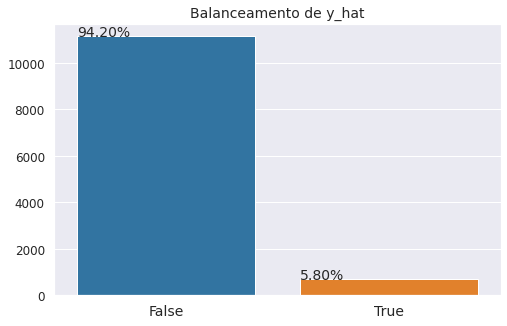

In [48]:
fig = plt.figure(figsize=(8,5))

ax = sns.barplot(
    x = df_pred.y_hat.value_counts().index,
    y = df_pred.y_hat.value_counts().values
)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/df_pred.y_hat.value_counts().values.sum() * 100), (p.get_x(), p.get_height()+0.5), rotation = 0)

plt.title("Balanceamento de y_hat", size=14)

del ax

In [34]:
y_hat_proba[:,1]

array([0.00760852, 0.00089622, 0.00919257, ..., 0.0244308 , 0.00077197,
       0.00058017], dtype=float32)

In [37]:
df_pred['y_hat_proba'] = y_hat_proba[:,1]
df_pred.head(10)

Valor  pure_time  same_day_count  \
Cartão           Data                                                     
400217******0059 2015-06-03 18:44:24  170.00  18.740000               1   
400217******3671 2015-06-02 22:01:56  111.65  22.032222               1   
400217******3689 2015-06-16 18:18:16   78.15  18.304444               1   
400217******3922 2015-06-15 17:17:06  110.00  17.285000               1   
400217******4160 2015-06-11 15:26:25   40.00  15.440278               1   
400217******5122 2015-06-23 14:40:39   36.00  14.677500               1   
400217******6763 2015-06-02 19:56:22  123.20  19.939444               5   
                 2015-06-02 19:57:45  123.20  19.962500               5   
                 2015-06-02 19:58:39  123.20  19.977500               5   
                 2015-06-02 19:59:34  123.20  19.992778               5   

                                      same_day_valor_count  rank_same_day  \
Cartão           Data                                                       
400217******0059 2015-06-03 18:44:24                     1            1.0   
400217******3671 2015-06-02 22:01:56                     1            1.0   
400217******3689 2015-06-16 18:18:16                     1            1.0   
400217******3922 2015-06-15 17:17:06                     1            1.0   
400217******4160 2015-06-11 15:26:25                     1            1.0   
400217******5122 2015-06-23 14:40:39                     1            1.0   
400217******6763 2015-06-02 19:56:22                     5            1.0   
                 2015-06-02 19:57:45                     5            2.0   
                 2015-06-02 19:58:39                     5            3.0   
                 2015-06-02 19:59:34                     5            4.0   

                                      diff_time  day_name_Friday  \
Cartão           Data                                              
400217******0059 2015-06-03 18:44:24   0.000000                0   
400217******3671 2015-06-02 22:01:56   0.000000                0   
400217******3689 2015-06-16 18:18:16   0.000000                0   
400217******3922 2015-06-15 17:17:06   0.000000                0   
400217******4160 2015-06-11 15:26:25   0.000000                0   
400217******5122 2015-06-23 14:40:39   0.000000                0   
400217******6763 2015-06-02 19:56:22   0.000000                0   
                 2015-06-02 19:57:45   0.023056                0   
                 2015-06-02 19:58:39   0.015000                0   
                 2015-06-02 19:59:34   0.015278                0   

                                      day_name_Monday  day_name_Saturday  \
Cartão           Data                                                      
400217******0059 2015-06-03 18:44:24                0                  0   
400217******3671 2015-06-02 22:01:56                0                  0   
400217******3689 2015-06-16 18:18:16                0                  0   
400217******3922 2015-06-15 17:17:06                1                  0   
400217******4160 2015-06-11 15:26:25                0                  0   
400217******5122 2015-06-23 14:40:39                0                  0   
400217******6763 2015-06-02 19:56:22                0                  0   
                 2015-06-02 19:57:45                0                  0   
                 2015-06-02 19:58:39                0                  0   
                 2015-06-02 19:59:34                0                  0   

                                      day_name_Sunday  ...  day_name_Tuesday  \
Cartão           Data                                  ...                     
400217******0059 2015-06-03 18:44:24                0  ...                 0   
400217******3671 2015-06-02 22:01:56                0  ...                 1   
400217******3689 2015-06-16 18:18:16                0  ...                 1   
400217******3922 2015-06-15 17:17:06                0  ...                 0   
400

# Previsão de Ticket Médio

## Convertido

In [42]:
df_pred[df_pred.y_hat==False]['Valor'].sum()

1256153.4500000002

In [43]:
len(df_pred[df_pred.y_hat==False])

11135

In [44]:
round(df_pred[df_pred.y_hat==False]['Valor'].sum()/len(df_pred[df_pred.y_hat==False]), 2)

112.81

## Não Convertido

In [45]:
df_pred[df_pred.y_hat==True]['Valor'].sum()

100664.92

In [46]:
len(df_pred[df_pred.y_hat==True])

685

In [47]:
round(df_pred[df_pred.y_hat==True]['Valor'].sum()/len(df_pred[df_pred.y_hat==True]), 2)

146.96

In [ ]:
https://blogbr.clear.sale/chargeback-saiba-o-que-quais-os-riscos-e-como-evit-lo